In [32]:
# Import necessary packages
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn. compose import ColumnTransformer 
from sklearn.metrics import *
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier,GradientBoostingClassifier, StackingClassifier
import xgboost as xgb
import stacking as sk

RANDOM_STATE : int = 42
TARGET_NAME : str = "target"

### candidates models
| Vectorizer |stop_words | ngram_range  |  min_df | max_features  |  max_df | Model| penalty | C 
|---|---|---|---|---|---|---|---|---|
| CountVectorizer |english |  (1, 2) | 2  |  3500 | 0.5  |  RandomForestClassifier(max_depth=20, n_estimators=100)| NaN|NaN |
| TfidfVectorizer/CountVectorizer |english |  (1, 1) | 2  |  3500 | 0.7  | RandomForestClassifier(max_depth=20, n_estimators=50)| NaN|NaN |
| TfidfVectorizer |english |  (1, 1)|  1 |  2000 |  0.7 | LogisticRegression(C=0.1, solver='saga')|	L2|  0.1|
| TfidfVectorizer/CountVectorizer |english |  (1, 2)|  2 |  3000 |  0.7 | GradientBoostingClassifier(max_depth=20, n_estimators=250)|NaN|NaN |

# Final Model 1: Voting based on candidates models
![](output/vt.png)
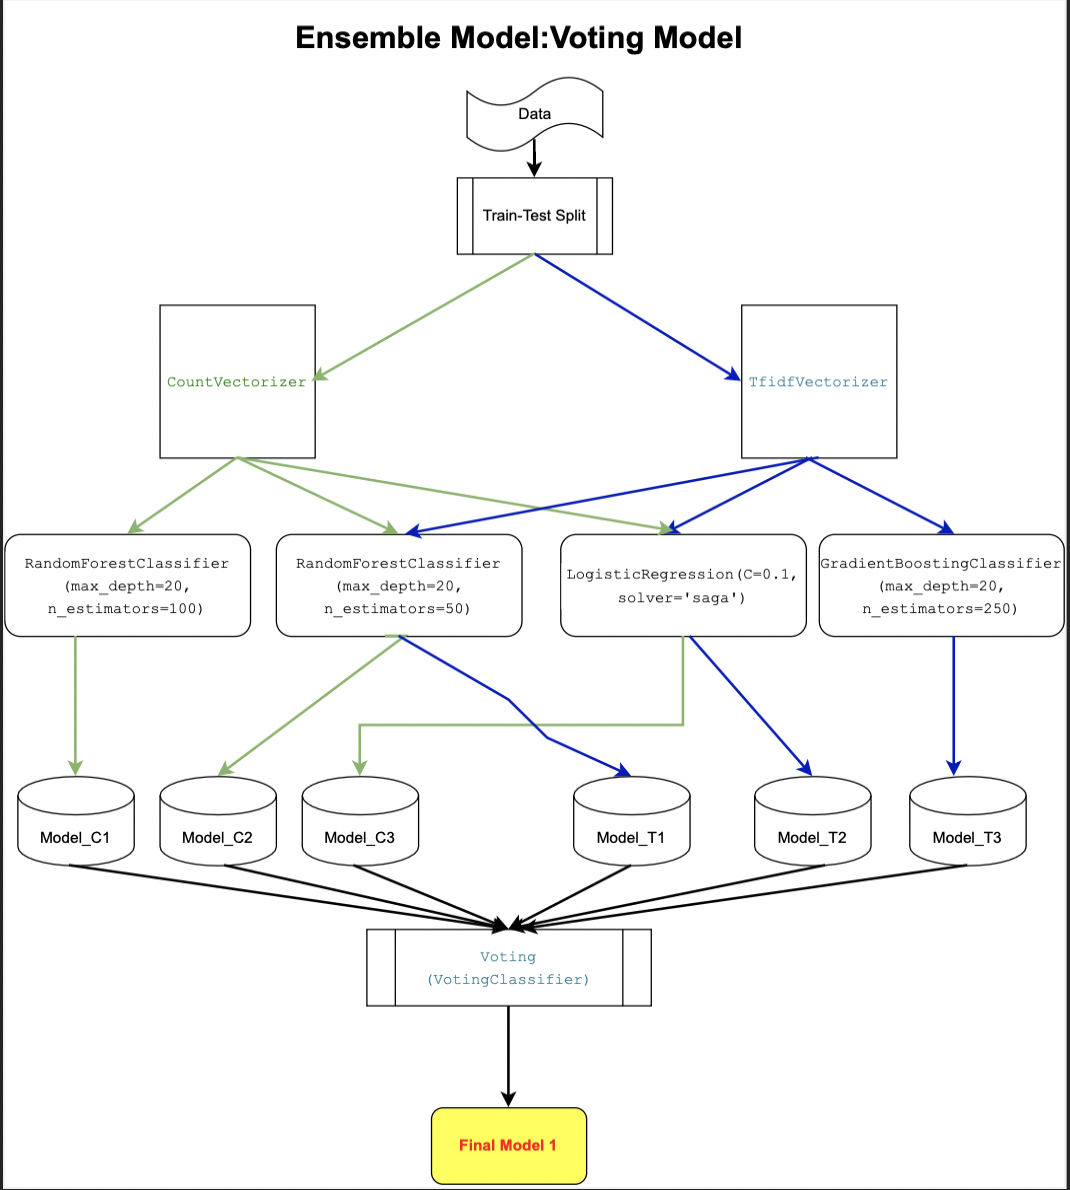

In [36]:
# Setting up the CountVectorizer for Classifiers (Estimators)
text_preprocessing_a = Pipeline([('Vect', CountVectorizer(stop_words='english', max_features=3500, min_df=2, max_df=0.5, ngram_range=(1,2)))])
text_preprocessing_b = Pipeline([('Vect', CountVectorizer(stop_words='english',max_features=3500, min_df=2, max_df=0.7, ngram_range=(1,1)))])
text_preprocessing_c = Pipeline([('Vect', CountVectorizer(stop_words='english',max_features=2000, min_df=1, max_df=0.7, ngram_range=(1,1)))])
text_preprocessing_d = Pipeline([('Vect', CountVectorizer(stop_words='english',max_features=3000, min_df=2, max_df=0.7, ngram_range=(1,2)))])

# Setting up the TfidfVectorizer for Classifiers (Estimators)
text_preprocessing_2 = Pipeline([('Vect', TfidfVectorizer(stop_words='english',max_features=3500, min_df=2, max_df=0.7, ngram_range=(1,1)))])
text_preprocessing_3 = Pipeline([('Vect', TfidfVectorizer(stop_words='english',max_features=2000, min_df=1, max_df=0.7, ngram_range=(1,1)))])
text_preprocessing_4 = Pipeline([('Vect', TfidfVectorizer(stop_words='english',max_features=3000, min_df=2, max_df=0.7, ngram_range=(1,2)))])

def pre(proc):
    return ColumnTransformer(
                            [('text_preprocessing', proc, 'lem_text')]
                            )

# Moodels with CountVectorizer                      
Model_C1 = Pipeline([
    ('pre', pre( text_preprocessing_a )),
    ('classifier', RandomForestClassifier(max_depth=20, n_estimators=100))
])

Model_C2 = Pipeline([
    ('pre', pre( text_preprocessing_b )),
    ('classifier', RandomForestClassifier(max_depth=20, n_estimators=50))
])

Model_C3 = Pipeline([
    ('pre', pre( text_preprocessing_d )),
    ('classifier', GradientBoostingClassifier(max_depth=20, n_estimators=250))
])

# Moodels with TfidfVectorizer
Model_T1 = Pipeline([
    ('pre', pre( text_preprocessing_2 )),
    ('classifier', RandomForestClassifier(max_depth=20, n_estimators=50))
])

Model_T2 = Pipeline([
    ('pre', pre( text_preprocessing_3 )),
    ('classifier', LogisticRegression(C=0.1, solver='saga'))
])

Model_T3 = Pipeline([
    ('pre', pre( text_preprocessing_4 )),
    ('classifier', GradientBoostingClassifier(max_depth=20, n_estimators=250))
])

In [6]:
df = pd.read_csv('data_nlp.csv')
df = df[['lem_text','y']]
y = df['y']
X = df.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
vote = VotingClassifier([
    ('Model_C1', Model_C1),
    ('Model_C2', Model_C2),
    ('Model_C3', Model_C3),
    ('Model_T1', Model_T1),
    ('Model_T2', Model_T2),
    ('Model_T3', Model_T3),], 
    voting='soft', 
    n_jobs=-1)

vote.fit(X_train, y_train)
print('Train score:',vote.score(X_train,y_train))
print('Test score:',vote.score(X_test,y_test))
print(classification_report(y_test,
                            vote.predict(X_test)))
# Scoring of test data
accuracy = accuracy_score(y_test,vote.predict(X_test))
precision = precision_score(y_test,vote.predict(X_test))
recall = recall_score(y_test,vote.predict(X_test))
df = pd.DataFrame([['voting',accuracy,precision,recall]], columns=['Final_Model','accuracy','precision','recall'])


Train score: 0.9992148065058889
Test score: 0.82907133243607
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1129
           1       0.82      0.83      0.83      1100

    accuracy                           0.83      2229
   macro avg       0.83      0.83      0.83      2229
weighted avg       0.83      0.83      0.83      2229



[[933 196]
 [185 915]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


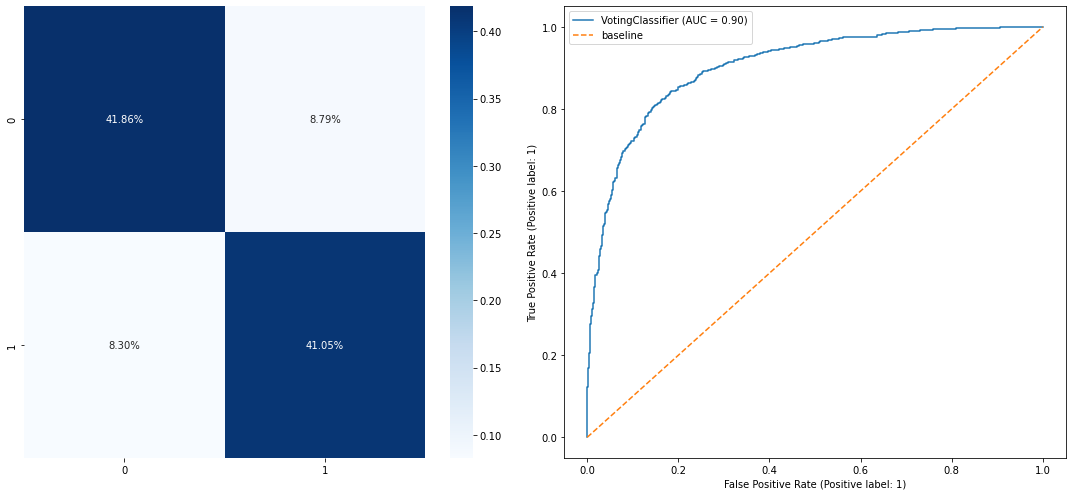

In [13]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = vote.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(vote, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

# Final Model 2: Boosting based on candidates models
![](output/ensMd2.png)

Reference:
https://xgboost.readthedocs.io/en/stable/tutorials/rf.html

In [22]:
xgb_pipeline1 = Pipeline([
    ('pre', ColumnTransformer([('text_preprocessing', text_preprocessing_a, 'lem_text')])),
    ('clf', xgb.XGBRFClassifier(max_depth=20, 
                                subsample=0.8, 
                                learning_rate= 1, 
                                colsample_bynode= 0.8, 
                                objective='binary:logistic'))
])

params1 = {
    'clf__n_estimators': [50,100],
    'clf__reg_lambda': [0,0.1,0.5],
    'clf__num_parallel_tree': [100, 300, 500]
}

xgb_pipeline2 = Pipeline([
    ('pre', ColumnTransformer([('text_preprocessing', text_preprocessing_2, 'lem_text')])),
    ('clf', xgb.XGBRFClassifier(n_estimators=50, 
                                max_depth=20, 
                                subsample=0.8, 
                                learning_rate= 1, 
                                colsample_bynode= 0.8, 
                                objective='binary:logistic'))
])

params2 = {
    'clf__reg_lambda': [0,0.1,0.5],
    'clf__num_parallel_tree': [100, 300, 500]
}

In [23]:
gs1 = GridSearchCV(xgb_pipeline1, param_grid=params1, cv=3)
gs1.fit(X_train, y_train)
print(gs1.best_score_)
gs1.best_params_

0.7604049780448326


{'clf__n_estimators': 50,
 'clf__num_parallel_tree': 100,
 'clf__reg_lambda': 0.1}

[[838 291]
 [240 860]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


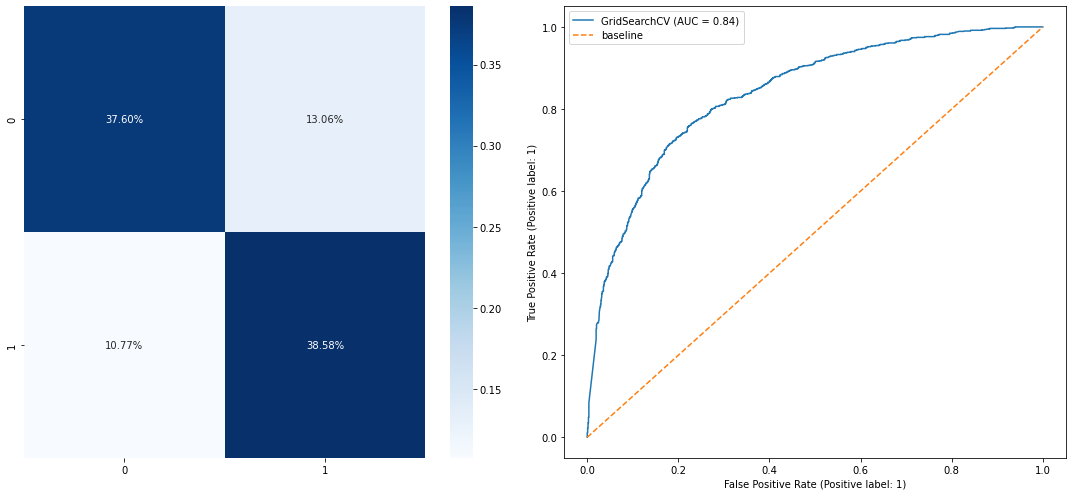

In [24]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = gs1.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(gs1, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

In [26]:
gs2 = GridSearchCV(xgb_pipeline2, param_grid=params2, cv=3)
gs2.fit(X_train, y_train)
print(gs2.best_score_)
gs2.best_params_

0.7588357109603994


{'clf__num_parallel_tree': 100, 'clf__reg_lambda': 0.1}

[[831 298]
 [227 873]]


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


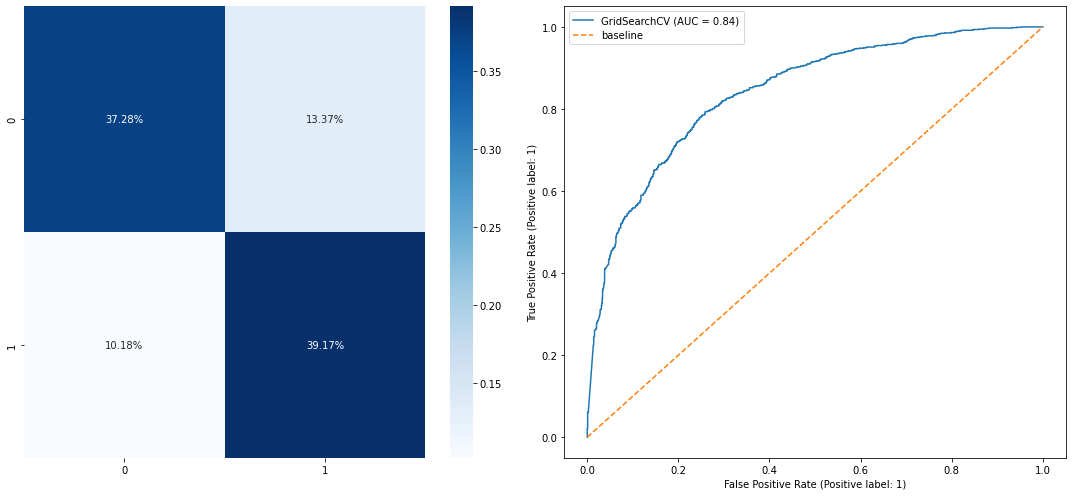

In [27]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = gs2.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(gs2, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

# Final Model 3: Stacking based on candidates models

![](output/Screenshot%202022-11-24%20at%201.25.04%20AM.png)

In [37]:
level_1_classifiers = dict()
level_1_classifiers["C1"] = Model_C1
level_1_classifiers["C2"] = Model_C2
level_1_classifiers["C3"] = Model_C3
level_1_classifiers["T1"] = Model_T1
level_1_classifiers["T2"] = Model_T2
level_1_classifiers["T3"] = Model_T3

# meta classifier
level_2_classifier = LogisticRegression(random_state=RANDOM_STATE)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
stacking_model = StackingClassifier(estimators=list(level_1_classifiers.items()), final_estimator=level_2_classifier, passthrough=True, cv=kfold, stack_method="predict_proba")

level_1_columns = [f"{name}_prediction" for name in level_1_classifiers.keys()]
pd.DataFrame(stacking_model.fit_transform(X_train, y_train), columns=level_1_columns + list(X_train.columns))


ValueError: could not convert string to float: 'hear forever stamp thinking secure investment utility appreciate backed reputable institution hit forever stamp figured degens would fun poking hole thesis forever stamp released may stamp forever stamp today may stamp year stamp appreciation mail letter mean come may attractive investment yield great return really resell marketplace blackmarket hot dog grandma interested dumping net worth forever stamp ampx bwhat thought'

In [ ]:
y_test_pred0 = stacking_model.predict(X_test)
y_test_pred0

In [ ]:

level_1 = sk.Level1Stacker(copy.deepcopy(level_1_classifiers), passthrough=True, save_x=True)
level_2 = sk.Level2Stacker(LogisticRegression(random_state=RANDOM_STATE))

final_stacking_model = Pipeline([
                            ('level_1', level_1), 
                            ('level_2', level_2) 
                            ])

final_stacking_model.fit(X_train, y_train)
#level_1.X

In [ ]:
y_test_pred = final_stacking_model.predict(X_test)
y_test_pred

In [ ]:
print(f"Accuracy of scikit-learn stacking classifier: {accuracy_score(y_test, y_test_pred)}")

for name, classifier in level_1_classifiers.items():
    classifier_ = copy.deepcopy(classifier)
    classifier_.fit(X_train, y_train)

    print(f"Accuracy of standalone {name} classifier: {accuracy_score(y_test, classifier_.predict(X_test))}")
